In [1]:
!pip install transformers datasets fsspec==2023.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.9.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_6

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from datasets import load_dataset, DatasetDict

def generate_dataset():
    base_dir = "/content/drive/MyDrive/split_dataset"

    train = load_dataset("audiofolder", data_dir=f"{base_dir}/train", split="train")
    val = load_dataset("audiofolder", data_dir=f"{base_dir}/validation", split="train")
    test = load_dataset("audiofolder", data_dir=f"{base_dir}/test", split="train")

    return DatasetDict({
        "train": train,
        "validation": val,
        "test": test
    })


In [4]:
dataset = generate_dataset()


Resolving data files:   0%|          | 0/2608 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/180 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/178 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
from transformers import ASTFeatureExtractor, ASTConfig, ASTForAudioClassification, TrainingArguments, Trainer

pretrained_model = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = ASTFeatureExtractor.from_pretrained(pretrained_model)
model_input_name = feature_extractor.model_input_names[0]
SAMPLING_RATE = feature_extractor.sampling_rate

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [ ]:
print(dataset["train"].features)

{'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None), 'label': ClassLabel(names=['with-speech-disorder', 'without-speech-disorder'], id=None)}


In [6]:
import torch
import numpy as np
from datasets import Audio

dataset = dataset.cast_column("audio", Audio(sampling_rate=SAMPLING_RATE))

dataset = dataset.rename_column("audio", "input_values")

def preprocess_audio(batch):
    wavs = [audio["array"] for audio in batch["input_values"]]
    inputs = feature_extractor(wavs, sampling_rate=SAMPLING_RATE, return_tensors="pt")
    return {
        model_input_name: inputs.get(model_input_name),
        "labels": batch["label"]
    }

feature_extractor.do_normalize = False
mean = []
std = []

dataset.set_transform(preprocess_audio, output_all_columns=True)

for batch in dataset["train"]:
    input_tensor = torch.tensor(batch[model_input_name])
    mean.append(torch.mean(input_tensor))
    std.append(torch.std(input_tensor))

feature_extractor.mean = np.mean(mean)
feature_extractor.std = np.mean(std)
feature_extractor.do_normalize = True


/tmp/ipython-input-6-769851435.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(batch[model_input_name])


In [11]:
from transformers import ASTConfig

config = ASTConfig.from_pretrained(pretrained_model)
config.num_labels = len(dataset["train"].features["label"].names)
config.label2id = {label: i for i, label in enumerate(dataset["train"].features["label"].names)}
config.id2label = {i: label for i, label in enumerate(dataset["train"].features["label"].names)}

model = ASTForAudioClassification.from_pretrained(pretrained_model, config=config, ignore_mismatched_sizes=True)

training_args = TrainingArguments(
    output_dir="./results",
    logging_dir="./logs",
    report_to="tensorboard",
    learning_rate=5e-5,
    push_to_hub=False,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_strategy="steps",
    logging_steps=20
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00


In [14]:
import evaluate


AVERAGE = "binary"

accuracy = evaluate.load("accuracy")
recall = evaluate.load("recall")
precision = evaluate.load("precision")
f1 = evaluate.load("f1")

def generate_metrics(eval_pred):
    logits = eval_pred.predictions
    predictions = np.argmax(logits, axis=-1)
    metrics = accuracy.compute(predictions=predictions, references=eval_pred.label_ids)
    metrics.update(precision.compute(predictions=predictions, references=eval_pred.label_ids, average=AVERAGE))
    metrics.update(recall.compute(predictions=predictions, references=eval_pred.label_ids, average=AVERAGE))
    metrics.update(f1.compute(predictions=predictions, references=eval_pred.label_ids, average=AVERAGE))
    return metrics

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=generate_metrics
)

In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.312700,0.422945,0.833333,0.913043,0.901840,0.907407
2,0.229700,0.537950,0.883333,0.922619,0.950920,0.936556
3,0.088600,0.655352,0.916667,0.925287,0.987730,0.955490
4,0.000000,0.865490,0.900000,0.923977,0.969325,0.946108
5,0.048900,0.925929,0.877778,0.922156,0.944785,0.933333
6,0.000000,1.031936,0.894444,0.923529,0.963190,0.942943
7,0.000000,1.074325,0.894444,0.923529,0.963190,0.942943
8,0.000000,1.099498,0.894444,0.923529,0.963190,0.942943
9,0.000000,1.114454,0.894444,0.923529,0.963190,0.942943
10,0.000000,1.119549,0.894444,0.923529,0.963190,0.942943


TrainOutput(global_step=3260, training_loss=0.07041578810112362, metrics={'train_runtime': 7702.1445, 'train_samples_per_second': 3.386, 'train_steps_per_second': 0.423, 'total_flos': 1.7677764644359373e+18, 'train_loss': 0.07041578810112362, 'epoch': 10.0})

In [16]:
print("Evaluating the model on the test set...")
metrics_test = trainer.evaluate(dataset["test"])
print("Test set metrics:", metrics_test)

Evaluating the model on the test set...


Test set metrics: {'eval_loss': 0.6572120785713196, 'eval_accuracy': 0.8932584269662921, 'eval_precision': 0.9137931034482759, 'eval_recall': 0.9754601226993865, 'eval_f1': 0.9436201780415431, 'eval_runtime': 160.6581, 'eval_samples_per_second': 1.108, 'eval_steps_per_second': 0.143, 'epoch': 10.0}


In [17]:
predictions = trainer.predict(dataset["test"])

In [18]:
import numpy as np

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)


In [19]:
from sklearn.metrics import classification_report

label_names = dataset["test"].features["label"].names

report = classification_report(y_true, y_pred, target_names=label_names, digits=4)
print("Metrics:\n")
print(report)

Metrics:

                         precision    recall  f1-score   support

   with-speech-disorder     0.0000    0.0000    0.0000        15
without-speech-disorder     0.9138    0.9755    0.9436       163

               accuracy                         0.8933       178
              macro avg     0.4569    0.4877    0.4718       178
           weighted avg     0.8368    0.8933    0.8641       178



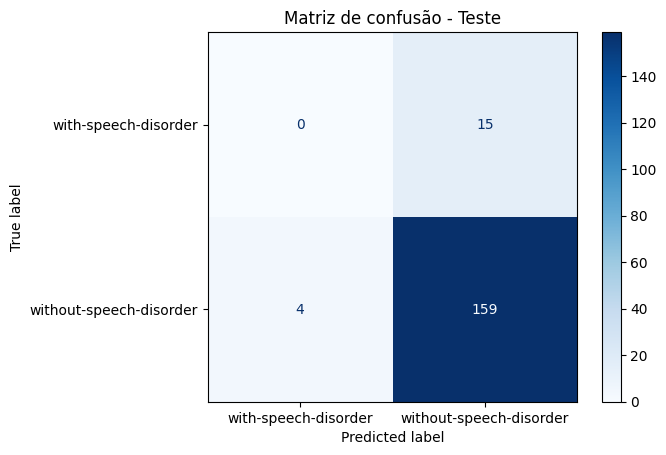

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de confusão - Teste")
plt.show()